In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split

from dataset import DogDataset
from model import UNet
from evaluate_model import evaluate_model

# Hyper parameters

In [ ]:
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_OF_CLASSES = 1
TAKE_INDEXES_BELOW = 31

# Loading data set

In [3]:
dog_dataset_dir = "DatasetOxford"
transform_for_unet = Compose([
    Resize((512,512)),
    ToTensor(),
])

dog_dataset = DogDataset(dataset_dir=dog_dataset_dir, indexes_below=TAKE_INDEXES_BELOW, transform=transform_for_unet)
print("Length of dataset: ", len(dog_dataset))




Length of dataset:  493


# Dividing data into train, validation and test sets

In [14]:
train_data_length = math.ceil(0.7 * len(dog_dataset))
validation_data_length = math.ceil(0.15 * len(dog_dataset))
test_data_length = len(dog_dataset) - train_data_length - validation_data_length

train_data, valid_data, test_data = random_split(dog_dataset, [train_data_length, validation_data_length, test_data_length])

print("Test dataset length: ", len(test_data))
print("Validation dataset length: ", len(valid_data))
print("Train dataset length: ", len(train_data))
print("Sum = ", (len(test_data) + len(valid_data) + len(train_data)))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Test dataset length:  73
Validation dataset length:  74
Train dataset length:  346
Sum =  493


# Visualising data

Data batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8, 1, 512, 512])
torch.Size([512, 512])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


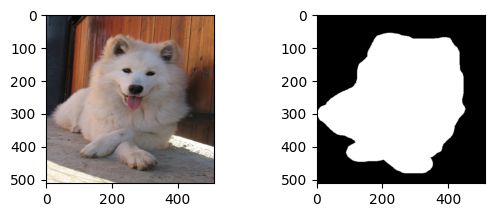

In [5]:
data_imges, label_imges = next(iter(train_dataloader))
print(f"Data batch shape: {data_imges.size()}")
print(f"Labels batch shape: {label_imges.size()}")

data_img = data_imges[0].permute(1, 2, 0).numpy()
label_img = label_imges[0].squeeze()

print(label_img.shape)
print(label_img)

figure = plt.figure()
ax1 = figure.add_subplot(2,2,1)
ax1.imshow(data_img)
ax2 = figure.add_subplot(2,2,2)
ax2.imshow(label_img, cmap="gray")
plt.show()

In [6]:
# torch.set_printoptions(threshold=10000000)
# print(label_img)
# torch.set_printoptions(threshold=1000)
print(torch.max(label_img))

tensor(1.)


# Model creation

### Checking if the model looks correct

In [7]:
input_image = torch.rand((1, 3, 512, 512))
model_test = UNet(num_classes=NUM_OF_CLASSES)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_test.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_test.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
outputs = model_test(input_image)
print(outputs.shape)

31,031,745 total parameters.
31,031,745 training parameters.
torch.Size([1, 1, 512, 512])


### Initializing a model

In [8]:
model = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training (without validation)

In [9]:
for epoch in range(EPOCHS):
    model.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    for idx, data in (enumerate(train_dataloader)):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        predicted_mask = model(img)
        optimizer.zero_grad()

        loss = loss_fn(predicted_mask, mask)
        single_loop_loss = loss.item()
        train_running_loss += single_loop_loss
        

        loss.backward()
        optimizer.step()
        print(f"    Batch {idx + 1} running loss: {single_loop_loss}")

    train_loss = train_running_loss / (idx + 1)

    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

Current EPOCH 1
    Batch 1 running loss: 0.6943968534469604
    Batch 2 running loss: 0.689908504486084
    Batch 3 running loss: 0.6879634857177734
    Batch 4 running loss: 0.6767268776893616
    Batch 5 running loss: 0.6864347457885742
    Batch 6 running loss: 0.6915345191955566
    Batch 7 running loss: 0.6958541870117188
    Batch 8 running loss: 0.6736249327659607
    Batch 9 running loss: 0.6832507848739624
    Batch 10 running loss: 0.6897070407867432
    Batch 11 running loss: 0.6765288710594177
    Batch 12 running loss: 0.6891160607337952
    Batch 13 running loss: 0.6864397525787354
    Batch 14 running loss: 0.677505612373352
    Batch 15 running loss: 0.6819780468940735
    Batch 16 running loss: 0.666024923324585
    Batch 17 running loss: 0.6863782405853271
    Batch 18 running loss: 0.6801062226295471
    Batch 19 running loss: 0.6734868288040161
    Batch 20 running loss: 0.6959289312362671
    Batch 21 running loss: 0.682735025882721
    Batch 22 running loss: 0.68

# Inference of a model

tensor([[[[0.1342, 0.0907, 0.0747,  ..., 0.1181, 0.1652, 0.2635],
          [0.0630, 0.0338, 0.0269,  ..., 0.0468, 0.0789, 0.1688],
          [0.0483, 0.0266, 0.0235,  ..., 0.0334, 0.0567, 0.1414],
          ...,
          [0.0442, 0.0173, 0.0111,  ..., 0.0059, 0.0158, 0.0702],
          [0.0760, 0.0352, 0.0251,  ..., 0.0149, 0.0306, 0.1054],
          [0.1716, 0.1063, 0.0811,  ..., 0.0606, 0.0940, 0.1897]]]],
       device='cuda:0')
MAX: 
1


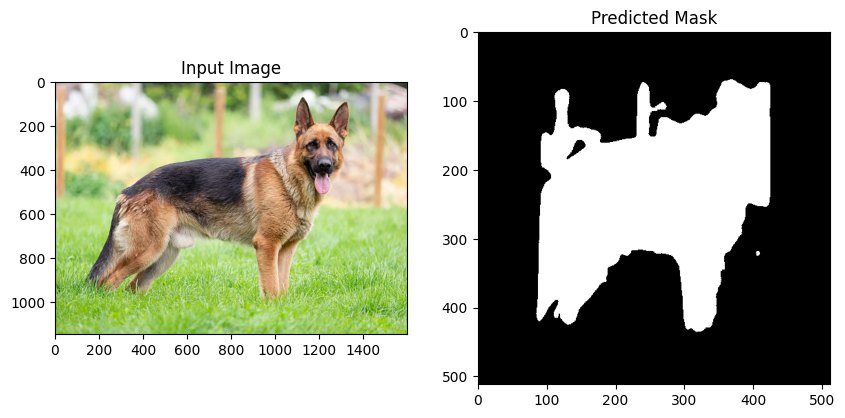

In [10]:
# Set the model in evaluation mode for inference
model.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
# test_image_path = "scottish_terrier_101.jpg"
# test_image_path = "inference_img.jpg"
test_image_path = "inference_img2.webp"
test_image = Image.open(test_image_path).convert("RGB")
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model(input_tensor)
    predicted_output = torch.sigmoid(predicted_output)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = predicted_output.squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.4).astype(int)  # Threshold at 0.5 to create a binary mask
print("MAX: ")
print(np.max(binary_mask))

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [11]:
mean_iou, mean_accuracy = evaluate_model(model, test_dataloader, device)

In evaluate
Mean IoU: 0.5155
Mean Accuracy: 0.7660


# Model with validation and adaptive learning rate

### Model initialization

In [12]:
model_w_valid = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_w_valid.to(device)

loss_fn_valid = nn.BCEWithLogitsLoss()
optimizer_valid = torch.optim.Adam(model_w_valid.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_valid, mode='min', factor=0.5, patience=3, verbose=True)

# Variable to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"  # File path to save the best model

c:\Users\MatG\Desktop\DataAnalysis\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training with validation

In [13]:
for epoch in range(EPOCHS):
    model_w_valid.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    # Training Loop
    for idx, data in enumerate(train_dataloader):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        # Forward pass
        predicted_mask = model_w_valid(img)
        optimizer_valid.zero_grad()

        # Compute loss
        loss = loss_fn_valid(predicted_mask, mask)
        train_running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer_valid.step()

    # Average training loss
    train_loss = train_running_loss / (idx + 1)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

    # Validation Loop
    model_w_valid.eval()
    val_running_loss = 0
    with torch.no_grad():
        for val_idx, val_data in enumerate(valid_dataloader):
            val_img = val_data[0].float().to(device)
            val_mask = val_data[1].float().to(device)

            # Forward pass for validation
            val_predicted_mask = model_w_valid(val_img)
            val_loss = loss_fn_valid(val_predicted_mask, val_mask)
            val_running_loss += val_loss.item()

    # Average validation loss
    val_loss = val_running_loss / (val_idx + 1)
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")

    # Checkpoint model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_w_valid.state_dict(), best_model_path)
        print(f"New best model saved with validation loss: {val_loss:.4f}")

    # Step the scheduler with the latest validation loss
    scheduler.step(val_loss)

    # Switch model back to training mode for the next epoch
    model_w_valid.train()

Current EPOCH 1
Train Loss EPOCH 1: 0.6915


TypeError: 'type' object is not iterable

### Inference of model with validation

In [ ]:
# Set the model in evaluation mode for inference
model_w_valid.load_state_dict(torch.load(best_model_path, map_location=device))
model_w_valid.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
# test_image_path = "scottish_terrier_101.jpg"
# test_image_path = "inference_img.jpg"
test_image_path = "inference_img2.webp"
test_image = Image.open(test_image_path).convert("RGB")
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model_w_valid(input_tensor)
    predicted_output = torch.sigmoid(predicted_output)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = predicted_output.squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.4).astype(int)  # Threshold at 0.5 to create a binary mask
print("MAX: ")
print(np.max(binary_mask))

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()

### Evaluation of a model with validation

In [ ]:
mean_iou, mean_accuracy = evaluate_model(model_w_valid, test_dataloader, device)